# System Dynamics

## Frame

We assume our blimp follows the north-east-down coordinate system. That is, the x axis points at the front, y axis points to the right of our blimp, and the z axis points down.

We assume the world frame's z axis points down as well.

## System Parameters
@Zhaoliang system paramters

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
pi = math.pi

# environment
g = 9.8
rho = 1.1 # air density

# blimp mass, assuming 100g=0.1kg
m = 0.1

# controller
phi = pi/18 # pitch

R_wb = np.array([[np.cos(phi),0,np.sin(phi)],
                 [0,1,0],
                 [-np.sin(phi),0,np.cos(phi)]]) # rotation matrix, given by attitude controller
R_bw = np.linalg.inv(R_wb)

# Shape hull + Gondola
# l_gz: z-distance from origin to aerodynamic center of Gondola (aram) 

C_D = np.array([1.8,1.8,2.5])

## Geometry

$⍴_{a}=⍴_{air}-⍴_{Hellium}$

$B = ⍴_{a}Vg $

$V = \frac{3}{4}\ * \pi *a*b*c $

In [ ]:
# Diameter
# Length: about 145cm height about 90cm
# Inflated size: 145 * 90 * 60cm
# https://www.amazon.com/Kengsiren-Control-Clownfish-Childrens-Artifact/dp/B086WCXX99
Dx = 1.1 # meters 
Dy = 0.5
Dz = 0.6
shaping_coeff = 0.9

# Volume
def calc_Volume(a,b,c):
  r_a = round(0.5*a,5)
  r_b = round(0.5*b,5)
  r_c = round(0.5*c,5)
  v = (pi * r_a * r_b * r_c)*3/4*shaping_coeff
  v = round(v,5)
  return v
V = calc_Volume(Dx,Dy,Dz)

# Surface area
area_xy = pi*Dx*Dy*0.25
area_xz = pi*Dx*Dz*0.25
area_yz = pi*Dy*Dz*0.25

A_body = np.array([area_yz,area_xz,area_xy])

# Arms
CG_to_CB_body = np.array([0,0,-1])

# Motor position @Zhaoliang
motor_pos = [[1,2,1],[],[]]
motor_orientation = [[],[],[]]
motor_speed = []
prop_radius = []

In [ ]:
A_body

array([0.23561945, 0.51836279, 0.43196899])

## Buoyancy
@Owen $F_B$ $M_{B,x},M_{B,y},M_{B,z}$

In [ ]:
# buoyancy

def calc_Buoyancy():
  F_B = rho * V *g #because we assume Z axis pointing downward, buoyancy force is therefore negative
  
  F_B_world = np.array([0,0,-F_B])
  F_B_body = R_bw @ F_B_world
  M_B_body = np.cross(F_B_body,CG_to_CB_body)
  return [F_B_world,M_B_body]  #[force on x, force on y, force on z, moment on x, moment on y, moment on z]

[F_B_world,M_B] = calc_Buoyancy()
F_B = np.abs(F_B_world[2])

print("Buoyancy = "+str(F_B))

Buoyancy = 0.9429266000000002


## Propulsion

@Zeyu Force $F_P=\begin{bmatrix}F_X\\F_Y\\F_Z\end{bmatrix}$, Moment $\begin{bmatrix}M_X\\M_Y\\M_Z\end{bmatrix}$

In [ ]:
# propulsion
 # Zeyu
import math
import numpy as np
p=1
w=2
r=3
a1=a2=b1=b2=c1=c2=1.5
i=1
lx=ly=lz=1
T=p*math.pow(w,2)*math.pow( r, 4 )*i
Fx=1.32*math.cos(a1)+1.32*math.cos(a2)
Fy=1.32*math.cos(b1)+1.32*math.cos(b2)
Fz=1.32*math.cos(c1)+1.32*math.cos(c2)
a1=np.array([[0,Fz,-Fy],[-Fz,0,Fx],[Fy,Fx,0]])
a2=np.array([lx,ly,lz])
M=np.dot(a1,a2)
print(a2)
print(Fx)
print(Fy)
print(Fz)
print(M)

[1 1 1]
0.18674621240273567
0.18674621240273567
0.18674621240273567
[0.         0.         0.37349242]


# Linear

The linear system dynamic in the world frame is (Ref: The GRASP Multiple Micro-UAV Testbed)

$$
m\begin{bmatrix}\dot v_x\\\dot v_y\\\dot v_z\end{bmatrix}=
\begin{bmatrix}0\\0\\mg-F_B\end{bmatrix}+
R_{wb}\begin{bmatrix}F_X-f_x(v_{x,\text{body}})\\F_Y-f_y(v_{y,\text{body}})\\F_Z+f_z(v_{z,\text{body}})\end{bmatrix}
$$

Where $m$ is the total mass of our blimp, $F_B$ is the buoyancy, $R_{wb}$ is the rotation matrix that translates body frame to world frame, $F$ are the propulsion provided by motors, and $f$ being the drag, which is a function of velocity.

## Steady State Analysis (Closed-form)
The terminal velocity has a closed-form solution when the acceleration on all 3 axes are 0. That is

$$
\begin{bmatrix}0\\0\\F_B-mg\end{bmatrix}=
R_{wb}\begin{bmatrix}F_X-f_x(v_{x,\text{max,body}})\\F_Y-f_y(v_{y,\text{max,body}})\\F_Z+f_z(v_{z,\text{max,body}})\end{bmatrix}
$$

Assuming that our attitude controller holds the blimp at a certain attitude with roll $\phi$ pitch $\theta$ and yaw $\psi$, captured by $R_{wb}=R(\phi,\theta,\psi)$.

The terminal velocity can thus be extracted from

$$
\begin{bmatrix}f_x(v_{x,\text{max,body}})\\f_y(v_{y,\text{max,body}})\\-f_z(v_{z,\text{max,body}})\end{bmatrix}=
\begin{bmatrix}F_X\\F_Y\\F_Z\end{bmatrix}
-R_{bw}\begin{bmatrix}0\\0\\F_B-mg\end{bmatrix}
$$

### Steady State Drag
$$f=\frac{1}{2} \rho v^{2} C_{D} A$$

$$\implies v_\text{max,body}=\sqrt{\frac{2f}{\rho C_D A}}$$

In [ ]:
f = F_p - R_bw @ np.array([0,0,F_B-m*g])
f[2] = -f[2]
v_max_body = np.sqrt(2*f/(rho*C_D*A_body))
v_max_world = R_wb @ v_max_body

print("max linear speed = "+str(v_max_body)+str(v_max_world))

max linear speed = [0.91093458 0.         0.52464765][0.98819955 0.         0.35849495]


## Transient Analysis (Simulation)
@Yifei

0 to $0.9v_\text{max}$ time

In [ ]:
def calculate_drag(v_world):
  v_body = R_bw@v_world
  fd = 0.5*rho*(v_body**2)*C_D*A_body
  fd[0] = -fd[0]
  fd[1] = -fd[1]
  return fd

def calculate_moment(v,alpha,beta):
  # CL2 in paper
  cdl = -1*(cdcg*Ref_Ag*l_gz)
  L =0.5*rho*v**2*(cdl*math.sin(beta)*math.sin(abs(beta)))
  # CM3 in paper
  cdm = -1*(cdch*J2*Ref_Ac*Dx)
  M =0.5*rho*v**2*(cdm*math.sin(alpha)*math.sin(abs(alpha)))
  # CN3 in paper
  cdn = -1*cdm
  N =0.5*rho*v**2*(cdn*math.sin(beta)*math.sin(abs(beta)))

  return L,M,N

In [ ]:
# here fx, fy, fz are netforce of propulsion, graivity, and buoyancy
# Assume 
def simluation_process(F_world):
  dt = 0.01;
  prev_v = np.zeros(3)
  vxs = []
  vys = []
  vzs = []
  # Angular
  alphas = []
  betas = []

  prev_alpha = 0
  prev_beta = 0
  # prev_alpha = alpha = math.atan(prev_vz/prev_vx)
  # prev_beta = math.asin(prev_vy/prev_v)
  n = 0
  while True:
    n += 1
    vxs.append(prev_v[0])
    vys.append(prev_v[1])
    vzs.append(abs(prev_v[2]))
    #Angular
    # alphas.append(prev_alpha)
    # betas.append(prev_beta)
    fd_body = calculate_drag(prev_v)
    fd_world = R_wb @ fd_body
    # Angular
    # L,M,N = calculate_moment(prev_v,prev_alpha,prev_beta)
    a = (F_world+fd_world)/m
    if n == 1000:
      break
    prev_v += a*dt
    

  
  # plot
  ns = range(0,n)
  plt.figure()
  plt.plot(ns,vxs,label='$v_x$')
  plt.plot(ns,vys,label='$v_y$')
  plt.plot(ns,vzs,label='$\|v_z\|$')
  plt.legend()
  plt.ylabel("Velocity(m/s)")
  plt.xlabel("time(/0.01s))")
  return


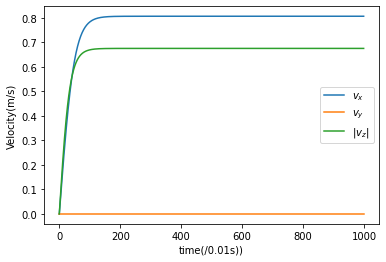

In [ ]:
# net force of propulsion, buoyancy and gravity in the world frame
F = R_wb @ F_p + F_B_world + np.array([0,0,m*g])
assert(F[2]<0)
simluation_process(F)

# Angular

The angular system dynamic in the blimp body frame is (ref: Parameter Identification of Blimp Dynamics through Swinging Motion)

$$
I \dot \omega + \omega \times (I\omega)=M
$$

Where $I$ is the moment of inertia matrix, $\omega$ is the angular velocity, and $M$ is the total moment on 3 axes.

## Steady State Analysis (Closed-form)

The factor limiting the maximum angular velocity is an aerodynamic damping moment, that can be assumed to be proportional to the angular velocity 

$$
M_d=\begin{bmatrix} -k_x \dot \phi \\ -k_y \dot \theta \\-k_z \dot \psi\end{bmatrix}
$$

Considering the fact that our blimp rotates rather slowly, the $w\times(Iw)$ term can also be omitted. Thus giving us

$$
I\dot \omega = M_p + M_t + M_d(\dot \phi,\dot \theta,\dot \psi)
$$

Where $M_p$ is the propulsion torque, and $M_t$ is the motor torque.

A closed-form terminal angular velocity can be obtained by setting $\dot \omega = 0$ and obtaining the corresponding roll pitch and yaw rate. That is

$$
M_d(\dot \phi_\text{max},\dot \theta_\text{max},\dot \psi_\text{max}) = -M_p - M_t
$$

In [ ]:
# Propulsion torque


## Transient Analysis (Simulation)